In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F
from tqdm import tqdm
from torchtext.vocab import build_vocab_from_iterator
from torchmetrics import Perplexity
import re
from torch.nn.utils import clip_grad_norm_
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [24]:
class AverageMeter:
    
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
    model.train()
    loss_train = AverageMeter()
    metric = Perplexity().to(device)
    with tqdm(train_loader, unit='batch') as tepochs:
        for x_batch, y_batch in tepochs:
            if epoch is not None:
                tepochs.set_description(f'epoch:{epoch}')
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            yp = model(x_batch.to(device))
            loss = loss_fn(yp.transpose(2, 1), y_batch)
            
            metric(yp, y_batch)
            loss.backward()
            clip_grad_norm_(model.parameters(), 0.25)
            optimizer.step()
            optimizer.zero_grad()
            tepochs.set_postfix(loss=loss_train.avg, ppl=metric.compute().item())
            loss_train.update(loss.item())
        loss = loss_train.avg
    return model, loss, metric.compute().item()

def generate(prompt, temp, many):
    model.eval()
    input_eval = [vocab[c] for c in prompt]
    with torch.no_grad():
        for i in range(many):
            model.eval()
            predictions = model(torch.LongTensor(input_eval).unsqueeze(0).to(device))
            predictions = (predictions.squeeze() / temp)
            arg = torch.multinomial(F.softmax(predictions, dim=-1), 1)[-1]
            input_eval.append(arg)
    text = ''.join(itos[c] for c in input_eval)
    return text


def evaluate(model, test_loader, loss_fn):
    model.eval()
    metric = Perplexity().to(device)
    loss_test = AverageMeter()
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            yp = model(x_batch)
            loss = loss_fn(yp.transpose(2, 1), y_batch)
            metric(yp, y_batch)
            loss_test.update(loss.item())
    print(f'perpelxity :{metric.compute()}, loss : {loss_test.avg}')
    return loss_test.avg, metric.compute().item()


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# READ AND CLEAN

In [6]:
with open('poet.txt') as f:
    text = f.read()
def clean(text):
    new_text = list()
    for i in text:
        if re.match('[ا-ی|\s]', i):
            new_text.append(i)
    text = ''.join(new_text).splitlines()
    return ''.join(text)
# dataset has afew character that could make our network a little confused about existance of them

In [7]:
text = clean(text)

#  PREPROCESS

In [8]:
vocab = build_vocab_from_iterator(text)
itos = vocab.get_itos()

In [9]:
char_map = torch.LongTensor([vocab[c] for c in text])

In [10]:
char_map = char_map.unfold(0, 100, 1)

In [11]:
x, y = (lambda x : (x[:, :-1], x[:, 1:]))(char_map)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(x, y, train_size=0.80)

In [13]:
train_set = TensorDataset(X_train, y_train)
valid_set = TensorDataset(X_valid, y_valid)

In [14]:
train_loader = DataLoader(train_set, shuffle=True, batch_size=70)
valid_loader = DataLoader(valid_set, shuffle=True, batch_size=70)

# MODEL

In [15]:
embedding_dim = 300
rnn_units = 500
num_layers = 2
vocab_size = len(vocab)

In [16]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, embedding_dim, rnn_units, num_layers, voc_size):
        super().__init__()
        self.embed = nn.Embedding(voc_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, rnn_units, batch_first=True, dropout=0.5, num_layers=num_layers)
        self.fc = nn.Linear(rnn_units, voc_size)
        self.dropout = nn.Dropout()
    def forward(self, x):
        x = self.dropout(self.embed(x))
        output, hn = self.rnn(x)
        y = self.fc(output)
        return y

In [ ]:
model = LSTMLanguageModel(embedding_dim, rnn_units, num_layers, vocab_size).to(device)

In [17]:
model = torch.load('model.pt')

In [18]:
sum(p.numel() for p in model.parameters())

3640841

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=5, weight_decay=1e-6)

In [20]:
loss_train_hist = list()
loss_valid_hist = list()
ppl_train_hist = list()
ppl_valid_hist = list()
best_loss_test = torch.inf

In [23]:
n = 30
epoch_counter = 0
for epoch in range(n):
    model, train_loss, train_metric  = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    valid_loss, valid_metric = evaluate(model, valid_loader, loss_fn)

    loss_train_hist.append(train_loss)
    loss_valid_hist.append(valid_loss)
    
    ppl_train_hist.append(train_metric)
    ppl_valid_hist.append(valid_metric)
    
    if valid_loss < best_loss_test:
        torch.save(model,'model.pt')
        best_loss_test =  valid_loss
        print('Model SAVED')
    epoch_counter +=1

epoch:0: 100%|█████| 8040/8040 [02:00<00:00, 66.89batch/s, loss=0.676, ppl=1.97]


perpelxity :1.5826128721237183, loss : 0.45907811795301107
Model SAVED


epoch:1: 100%|█████| 8040/8040 [01:59<00:00, 67.12batch/s, loss=0.671, ppl=1.96]


perpelxity :1.5733574628829956, loss : 0.45321022028946756
Model SAVED


epoch:2: 100%|█████| 8040/8040 [01:59<00:00, 67.28batch/s, loss=0.667, ppl=1.95]


perpelxity :1.5724685192108154, loss : 0.4526471684672939
Model SAVED


epoch:3:  52%|██▌  | 4160/8040 [01:01<00:57, 67.59batch/s, loss=0.663, ppl=1.94]


KeyboardInterrupt: 

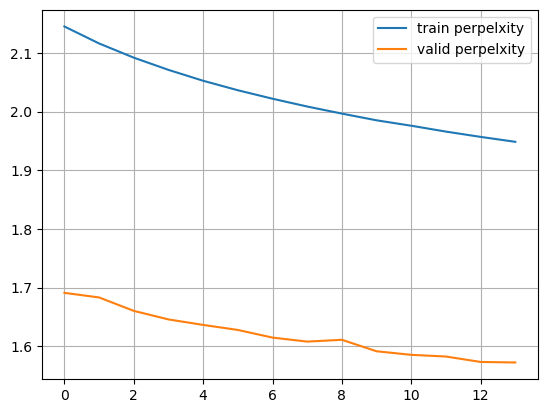

In [25]:
plt.plot(ppl_train_hist, label='train perpelxity')
plt.plot(ppl_valid_hist, label='valid perpelxity')
plt.legend()
plt.grid(True)

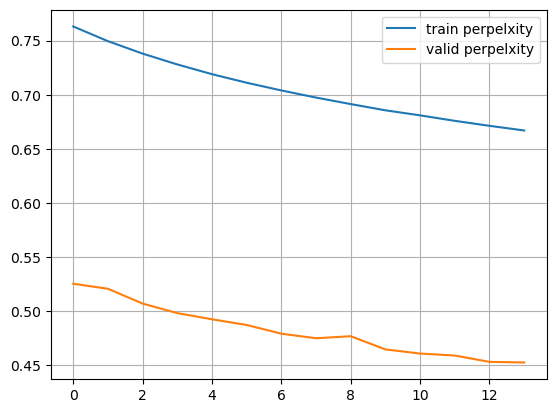

In [26]:
plt.plot(loss_train_hist, label='train perpelxity')
plt.plot(loss_valid_hist, label='valid perpelxity')
plt.legend()
plt.grid(True)

In [52]:
generate('طلب', temp=0.2, many=700).split('|')

['طلب از ياد نرگس می شمارم باده ده',
 'که از ن يوسف مه و پی نادی کنند',
 'پس به دم خود ار با حرم کردم چو من',
 'نیست این شاهان و ظاهر بر مرا',
 'دل چه می گوید بدیشان ای عجب',
 'طالهٔ خود خواجه اش در پی دود',
 'باز نور نور دل نور خداست',
 'کو ز دجله غالف از درد شدم',
 'کو به زین حال و هزاران را شناخت',
 'زانک این دو چشم را از نور روز',
 'تا نماند در جهان چون روم و زند',
 'زانک تش شد همچو سبزهٔ ضعیف',
 'تا همان رنجوری تو از خوی تن',
 'تا هلال روح می کشد از گمان',
 'چونک شد از شه گرد چاریک سر',
 'چون به خلق از می زنند و می زند',
 'زن دو سه جان پیمورشی نشست',
 'عشق از نخست که ز لعل هنگشار',
 'تو را ز است که ما را همی بری',
 'حافظ بر در انگشته غم باشد',
 'به ياد يار و ديار ن چنان بگريم',
 'جای تطبير من از جان بوسه سرش',
 'تو شها را ن سبو را باز گرد',
 'گفت چون وهمست ما هر روز نیست',
 'گشت رسمت ک']